In [0]:
# Import dependencies
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from  stats_helper import *
def dis_res(x):
    display(Markdown('___\n##### **Result**: \n\n' + x + '\n___'))

# Estimating the gobal mass of leaves

As part of our procedure for estimating the total number of Rubisco enzymes in the world, we first estimate the total mass of leaves globally.

To achieve a global estimate of leaf mass we rely on two independent methodologies. The first is based on measurement of the total plant biomass and the mass fraction of leaves out of the total leaf biomass, and the second is based on estimating the total leaf area and converting the total leaf area into leaf mass.

## Method 1 - leaf mass fraction


To estimate the total leaf mass based on mass frations, we combine estimates from Erb et al. on plant biomass in each biome, along with estimates of the average leaf mass fraction in each biome. Our estimates of the average leaf mass fraction in each biome are based a recent meta-analysis which collected data on the lead, shoot and root mass fractions in several different biomes [(Poorter et al.)](http://dx.doi.org/10.1111/j.1469-8137.2011.03952.x). Here is the data:

In [9]:
# Load data from Poorter et al.
fractions = pd.read_excel('../data/literature_data.xlsx','Poorter',skiprows=1,index_col=0)
fractions

,LMF,0.05,median,95,lower-fold,upper-fold,95% CI
Biome,,,,,,,
Tundra,0.09,0.005698,0.031339,0.248575,5.500000,7.931818,6.604922
Grassland,0.17,0.009972,0.070513,0.509259,7.071429,7.222222,7.146428
Boreal forest,0.04,0.006410,0.023504,0.095442,3.666667,4.060606,3.858612
Temperate forest,0.03,0.006410,0.019231,0.049145,3.000000,2.555556,2.768875
Tropical forest,0.02,0.006410,0.019231,0.029915,3.000000,1.555556,2.160247
Woodland,0.06,0.033476,0.048433,0.101140,1.446809,2.088235,1.738182
Shrubland,0.09,0.032051,0.096154,0.140313,3.000000,1.459259,2.092314
Desert,0.09,0.023504,0.043447,0.262821,1.848485,6.049180,3.343923


The data in Poorter et al. does not include values for croplands. To estimate the mean leaf mass fraction in crops, we use a recent dataset published by the same authors ([Poorter et al.](https://doi.org/10.1111/nph.13571)). We calculate the geometric mean of the leaf mass fraction across the top 20 largest crops based on FAO data.

In [0]:
# Define crop species
crop_species = ['Saccharum officinarum','Zea mays','Triticum aestivum','Triticum compactum','Triticum dicoccoides','Triticum dicoccoides x A. squarrosa','Triticum durum','Triticum monococcum','Triticum spelta','Triticum timopheevii','Triticum turgidum','Oryza sativa','Solanum tuberosum','Glycine max','Elaeis guineensis','Beta vulgaris','Manihot esculenta','Solanum lycopersicum','Hordeum vulgare','Musa spec.','Malus domestica','Cucumis sativus','Vitis vinifera']

# Load data from Poorter et al.
LMF_species = pd.read_excel('../data/literature_data.xlsx','Poorter2015')

# Lookup crop species in Poorter et al.
crop_LMF = LMF_species[LMF_species.Species.isin(crop_species)]

# Calculate the geometric mean of the leaf mass fraction and use it as the fraction for crops
fractions.loc['Cropland','LMF'] = gmean(crop_LMF.groupby('Species')['LMF'].mean())

We calculate weighted mean of leaf mass fraction. We use the fraction of total plant biomass in each biome as our weights from [Erb et al.](https://doi.org/10.1038/nature25138) for the weighted mean. Here is the data from Erb et al.:

In [38]:
# Load data on the total plant biomass in each biome from Erb et al.
biomes = pd.read_excel('../data/literature_data.xlsx','Erb',skiprows=1,index_col=0)
biomes

,Total biomass [Gt C],Categories included in Poorter,Remarks
Biome,,,
Tropical forests,257.063700,Tropical forest,Includes tropical forests under managements an...
Temperate forests,39.458988,Temperate forest,Includes tropical forests under managements an...
Boreal forests,35.977312,Boreal forest,Includes tropical forests under managements an...
Cropland,10.000000,Cropland,NaN
Other wooded land,57.000000,Shrubland,NaN
Natural grasslands,19.000000,Grassland,NaN
Artifitial grasslands,7.000000,Grassland,NaN
Unused non-forest,16.500000,Tundra,"Includes the category ""Wilderness, productive,..."


The specific biomes in Erb et al. are not fully matching the biomes in Poorter et al., and thus we traslate between the biomes in the two studies, and then merge the data. After we merge the data, we calculate the weighted average of the leaf mass fraction using the biomass of each biome as the weights:

In [0]:
# Merge LMF data with the biomass of each biome
biome_LMF = biomes.merge(fractions,left_on='Categories included in Poorter',right_index=True)

# Calculate the weighted average of the LMF
mean_LMF = np.average(biome_LMF['LMF'],weights=biome_LMF['Total biomass [Gt C]'])

We also use the data in poorter et al. to calculate the leaf mass fraction over all the grasses family except our crop species, to generate an additional estimate of the leaf mass fraction in grasslands:

In [47]:
# Create a copy of the biome_LMF dataframe
biome_LMF2 = biome_LMF.copy()

# 
grassland_species = LMF_species.loc[~(LMF_species.Species.isin(crop_species)) & (LMF_species.Family == 'Poaceae')]


,ID,Species,Family,Author,Source,LDM,SDM,RDM,TDM,LMF,SMF,RMF,SizeClass,pLMF,pSMF,pRMF
456,po2442,Aegilops biuncialis,Poaceae,Villar et al. (2005),Plant Soil 272: 11-27,0.01171,0.00364,0.00916,0.02452,0.4778,0.1485,0.3738,3,36.160714,37.500000,73.214286
457,po2443,Aegilops biuncialis,Poaceae,Villar et al. (2005),Plant Soil 272: 11-27,0.04700,0.02646,0.02928,0.10300,0.4570,0.2580,0.2850,6,26.339286,82.589286,44.196429
458,po2444,Aegilops biuncialis,Poaceae,Villar et al. (2005),Plant Soil 272: 11-27,0.24813,0.14654,0.08656,0.48100,0.5160,0.3050,0.1800,11,59.641256,83.856502,11.210762
459,po2475,Aegilops caudata,Poaceae,Villar et al. (2005),Plant Soil 272: 11-27,0.00993,0.00424,0.00584,0.02000,0.4960,0.2120,0.2920,2,45.291480,79.372197,42.152466
460,po2476,Aegilops caudata,Poaceae,Villar et al. (2005),Plant Soil 272: 11-27,0.02311,0.01478,0.01868,0.05700,0.4090,0.2610,0.3300,4,13.901345,86.098655,56.502242
461,po2477,Aegilops caudata,Poaceae,Villar et al. (2005),Plant Soil 272: 11-27,0.11778,0.08449,0.04931,0.25200,0.4680,0.3360,0.1960,9,43.750000,95.535714,13.392857
462,po2451,Aegilops columnaris,Poaceae,Villar et al. (2005),Plant Soil 272: 11-27,0.01054,0.00374,0.01479,0.02900,0.3630,0.1290,0.5090,3,8.928571,29.464286,96.428571
463,po2452,Aegilops columnaris,Poaceae,Villar et al. (2005),Plant Soil 272: 11-27,0.04743,0.02414,0.03563,0.10700,0.4420,0.2250,0.3320,6,21.875000,72.321429,66.071429
464,po2453,Aegilops columnaris,Poaceae,Villar et al. (2005),Plant Soil 272: 11-27,0.13841,0.06914,0.06861,0.27600,0.5010,0.2500,0.2480,9,54.464286,76.339286,29.464286
465,po2481,Aegilops comosa,Poaceae,Villar et al. (2005),Plant Soil 272: 11-27,0.01250,0.00609,0.01324,0.03200,0.3930,0.1910,0.4160,3,13.839286,60.714286,83.482143


In [0]:
# Calculate the sum of the mass fractions of leaves and roots
leaf_frac = fractions[['LMF','95% CI']]

# Calculate the total biomass of each biome by the biomes reported in Poorter et al.
tot_biomass = biomes.groupby('Categories included in Poorter').sum()

# For the temperate steppe, desert and mountain, we use the mean values from grassland and shrubland in Poorter et al.
leaf_frac.loc['Grassland, shrubland'] = (np.array([leaf_frac.loc['Grassland'],leaf_frac.loc['Shrubland']])).mean(0)

# Set the non-woody fraction as a column in the biome data
tot_biomass['Leaf fraction'] = leaf_frac['LMF']
tot_biomass['95% CI'] = leaf_frac['95% CI']

# Calculate the weighed average of the non-woody biomass fraction
mean_leaf_frac = np.average(tot_biomass['Leaf fraction'], weights= tot_biomass['Total biomass [Gt C]'])
dis_res('Our global average for the leaf mass fraction is ≈%.0f percent' %(mean_leaf_frac*100))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


___
##### **Result**: 

Our global average for the leaf mass fraction is ≈5 percent
___

To estimate the total mass of leaves, we rely on our estimate of the total plant biomass ([Bar-On et al.](https://doi.org/10.1073/pnas.1711842115)) of ≈450 Gt C, and we assume carbon is about 50% of the dry weight of plants. We thus estimate ≈900 Gt plant dry weight. We multiply the global leaf mass fraction by the total dry mass of plants to get an estimate for the total mass of leaves.

In [0]:
global_plant_mass =900e15
global_leaf_mass = global_plant_mass*mean_leaf_frac
dis_res('Our estimate for the global leaf mass based on leaf mass fraction measurements is ≈%.0f Gt' %(global_leaf_mass/1e15))

___
##### **Result**: 

Our estimate for the global leaf mass based on leaf mass fraction measurements is ≈41 Gt
___

## Method 2 - Remote sensing based leaf mass

In the notebook [**```remote_sensing_based_leaf_mass.ipynb```**](01_remote_sensing_based_leaf_mass.ipynb) we estimate that the total mass of leaves is ≈20 Gt.

As our best estimate for the total mass of leaves, we use the geometric mean of the two methods:

In [0]:
best_leaf_mass = np.sqrt(global_leaf_mass*20e15)
dis_res('Our best estimate for the global leaf mass is ≈%.0f Gt' %(best_leaf_mass/1e15))

___
##### **Result**: 

Our best estimate for the global leaf mass is ≈29 Gt
___

# Uncertainty analysis
To project the uncertainty associated with the estimate of the total mass of leaves, we first calculate the uncertainty around our estimate of the total mass of leaves based on the leaf mass fraction in each biome:

In [0]:
leaf_mass_per_biome = tot_biomass['Total biomass [Gt C]']*tot_biomass['Leaf fraction']
mul_CIs = tot_biomass['95% CI']
leaf_mass_frac_CI = CI_sum_prop(leaf_mass_per_biome,mul_CIs)
dis_res('Our projection for the uncertainty associated with our estimate of the mass fraction of leaves is ≈%.0f-fold' %leaf_mass_frac_CI)

___
##### **Result**: 

Our projection for the uncertainty associated with our estimate of the mass fraction of leaves is ≈2-fold
___

As for the total mass of plants, [Bar-On et al.](https://dx.doi.org/10.1073/pnas.1711842115) projected an uncertainty of ≈1.2-fold associated with the total mass of plants. We combine the uncertainty associated with our estimate of the leaf mass fraction with the uncertainty associated with the total mass of plants:

In [0]:
tot_leaf_mass_frac_CI = CI_prod_prop([leaf_mass_frac_CI,1.2])
dis_res('Our projection for the uncertainty associated with our estimate of the total mass of leaves based on leaf mass fraction is ≈%.0f-fold' %tot_leaf_mass_frac_CI)

___
##### **Result**: 

Our projection for the uncertainty associated with our estimate of the total mass of leaves based on leaf mass fraction is ≈2-fold
___

In the notebook [**```remote_sensing_based_leaf_mass.ipynb```**](01_remote_sensing_based_leaf_mass.ipynb) we estimate that the uncertainty associated with the estimate of the total mass of leaves based on remote sensing is ≈2-fold. We can calculate the uncertainty based on the difference of the estimates based on the two different methodologies (leaf mass based and remote sensing based):


In [0]:
mul_CI([global_leaf_mass,20e15])

1.8334987463289107

Overall, we use the highest uncertainty out of the uncertainties reported for each estimate and the uncertainty based on the difference between the different methodologies, which is ≈2-fold.

In [0]:
true_mean = 1
true_std = 10
sample_size = 1000

results = []
for i in range(1000):
    dist = np.random.lognormal(np.log(true_mean),true_std,sample_size)
    log_dist = np.log(dist)
    mul_CI = np.exp(log_dist.std()/np.sqrt(1000)*1.96)
    gmean = np.exp(log_dist.mean())
    results.append((true_mean > gmean/mul_CI) and (true_mean < gmean*mul_CI))

results = np.stack(results)

print(results.sum()/1000)

0.953


In [0]:
true_mean = 1
true_std = 10
sample_size = 1000

results = []
values = []
for i in range(1000):
    dist = np.random.lognormal(np.log(true_mean),true_std,sample_size)
    log_dist = np.log(dist)
    mul_CI = np.exp(log_dist.std()*1.96)
    gmean = np.exp(np.random.choice(log_dist))
    values.append(gmean)
    results.append((true_mean > gmean/mul_CI) and (true_mean < gmean*mul_CI))

results = np.stack(results)
values = np.stack(values)
print(results.sum()/1000)

0.945


(array([ 999.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.]),
 array([  6.04718851e-15,   1.97883927e+16,   3.95767855e+16,
          5.93651782e+16,   7.91535709e+16,   9.89419637e+16,
          1.18730356e+17,   1.38518749e+17,   1.58307142e+17,
          1.78095535e+17,   1.97883927e+17]),
 <a list of 10 Patch objects>)

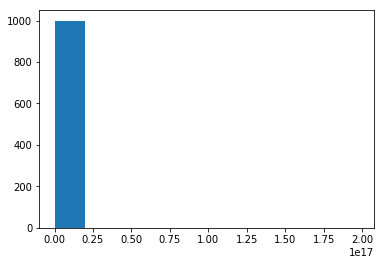

In [0]:
plt.hist(values)